# Don't Hate, Collaborate
This notebok is for the photometric and I and V band data for Nova Musca 1991 taken with SMARTS/ANDCIAM which we are collaborating with Jeff McClintock et al.

In the IPython Notebook "NovaMuscaCalibration" we detailed how we generated all the data for Nova Musca, including its calibration and other stuff. 

This notebook is jut about identifying the horrible outliers and packaging the data nicely for Jeff and his team

In [48]:
#start off by importing some useful things
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#the punch line of the last notebook was these two output files, which have calibrated data and other meta data
NMI=pd.read_csv('NMI.csv')
NMV=pd.read_csv('NMV.csv')

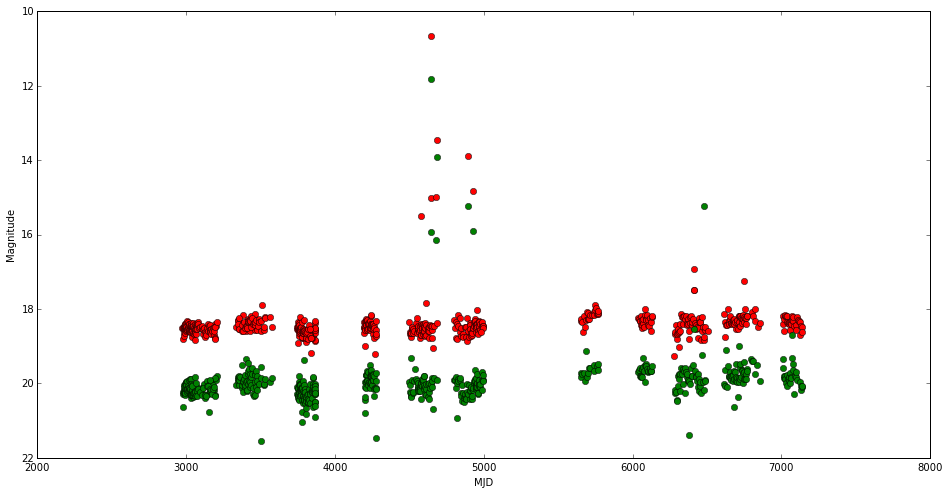

In [3]:
#here's a quick light curve of what we've got so far
#there are some horrifically catastrophic outliers, as you can see
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)

ax.plot(NMI.juliandate - 2450000, NMI.NMcal, 'ro')
ax.plot(NMV.juliandate- 2450000, NMV.NMcal, 'go')

ax.invert_yaxis()
ax.set_ylabel('Magnitude')
ax.set_xlabel('MJD')

In [5]:
#lets try to identify some of the outliers
#for I we can see there is a population that appear too bright for their own good.
NMI[(NMI.NMcal < 17.9)| (NMI.NMraw > 25)]

,Unnamed: 0,date,juliandate,NMraw,mag3,mag4,mag5,mag9,mag10,mag17,mag19,mag20,merr1,offset,std,NMcal
164,164,80422,2454579.65786,22.196,19.014,19.511,21.439,19.205,42.278,20.567,19.518,20.519,0.043,6.701375,8.451598,15.494625
181,181,80525,2454612.57781,22.262,19.699,20.207,22.142,19.903,19.081,21.268,20.215,21.242,0.028,4.414625,0.016587,17.847375
189,189,80627,2454645.55594,22.434,19.072,19.575,21.417,NaN,43.969,20.639,19.571,20.557,0.045,7.408571,9.657217,15.025429
190,190,80628,2454646.57908,22.130,19.383,19.885,21.767,NaN,70.414,20.906,19.886,20.928,0.030,11.461286,19.531267,10.668714
196,196,80729,2454677.47448,22.190,19.118,19.609,21.470,19.349,45.565,20.667,19.602,20.593,0.034,7.191625,9.581687,14.998375
198,198,80807,2454686.47433,22.093,18.970,19.478,21.303,NaN,53.220,20.495,19.480,20.455,0.036,8.637286,13.194706,13.455714
219,219,90303,2454894.73664,17.855,19.270,19.764,21.596,19.467,18.645,20.822,19.797,20.770,0.001,3.961375,0.031131,13.893625
230,230,90407,2454929.65996,21.941,19.051,19.549,21.499,NaN,41.964,20.615,19.566,20.536,0.034,7.120000,8.900324,14.821000
277,277,110706,2455749.54361,21.930,19.362,19.847,21.696,19.547,18.704,20.891,19.879,20.911,0.030,4.049625,0.034176,17.880375
339,339,130427,2456410.69824,20.677,19.016,19.551,21.562,19.244,18.412,20.593,19.553,20.560,0.019,3.756375,0.040907,16.920625


index 246, 271, 272, 278 and 280 look like something went wrong with their offset calculation. the variances of the offset are very large, and the instrumental magnitudes for star 10 are enormous. it looks like star 10 was falling of the detector on those nights. lets just throw those away.
I suspect source confusion for 301, because nova musca's raw instrumental magnitude is abnormally high.
index 421 and 479 look brighter than normal, but I can't rule them out otherwise. Lets look closer at these to see if they indeed do suffer from source confusion

In [6]:
#we also made these two output files which detail the x and y coordinate shift in nova musca's calculated centroid
#from iraf's photometry
Ideltaxy=pd.read_table('Ixyshift.out', names=['image','juliandate','id','xshift','yshift'], sep='\s+')
#lets look for points where the change in either the x or y direction for NM was greater than 2 pixels
Ideltaxy[(Ideltaxy.id == 1) & ((np.abs(Ideltaxy.xshift) > 3 ) 
                               | (np.abs(Ideltaxy.yshift) > 3))]

,image,juliandate,id,xshift,yshift
7100,rccd080628.0036_gregist,2454646.57908,1,3.079,-0.331
7680,rccd090303.0070_gregist,2454894.73664,1,28.944,-10.692
10080,rccd130427.0056_gregist,2456410.69824,1,11.421,-7.149
10100,rccd130501.0051_gregist,2456414.61704,1,4.963,-1.405
10120,rccd130501.0052_gregist,2456414.61704,1,4.963,-1.405
11240,rccd140403.0054_gregist,2456751.62630,1,8.370,-5.581


our suspicions were confirmed! the centroids marked in the photometry for data taken 90303, 130427, and 140403 are indeed suffering from source confusion. we should throw them out as well, along with these other points we found. lets find their indexes as well so we can throw them out.
I examined the remainder by hand and saw they have cosmic rays near NM

In [7]:
badshiftdates=Ideltaxy[(Ideltaxy.id == 1) & ((np.abs(Ideltaxy.xshift) > 3 ) 
                               | (np.abs(Ideltaxy.yshift) > 3))].juliandate

NMI[NMI.juliandate.isin(badshiftdates.values)]

,Unnamed: 0,date,juliandate,NMraw,mag3,mag4,mag5,mag9,mag10,mag17,mag19,mag20,merr1,offset,std,NMcal
190,190,80628,2454646.57908,22.130,19.383,19.885,21.767,NaN,70.414,20.906,19.886,20.928,0.030,11.461286,19.531267,10.668714
219,219,90303,2454894.73664,17.855,19.270,19.764,21.596,19.467,18.645,20.822,19.797,20.770,0.001,3.961375,0.031131,13.893625
339,339,130427,2456410.69824,20.677,19.016,19.551,21.562,19.244,18.412,20.593,19.553,20.560,0.019,3.756375,0.040907,16.920625
340,340,130501,2456414.61704,22.578,20.391,20.874,22.790,20.595,19.760,21.883,20.896,21.863,0.055,5.076500,0.021374,17.501500
341,341,130501,2456414.61704,22.578,20.391,20.874,22.790,20.595,19.760,21.883,20.896,21.863,0.055,5.076500,0.021374,17.501500
397,397,140403,2456751.62630,21.055,19.110,19.611,21.508,19.312,18.465,20.672,19.639,20.619,0.017,3.812000,0.008000,17.243000


In [16]:
#alright, now lets gather these all up by their indicies and store them
indeciesToDropI=NMI[(NMI.NMcal < 17.9) | (NMI.NMraw > 25)].index.append(NMI[NMI.juliandate.isin(badshiftdates.values)].index)

now we need to do a simmilar exercise with the V band data. There are also some points that are just too faint for their own good as well.

In [18]:
NMV[(NMV.NMraw > 25) | (NMV.NMcal < 19.)]

,Unnamed: 0,date,juliandate,NMraw,mag3,mag4,mag9,mag10,mag17,mag19,mag20,merr1,offset,std,NMcal
69,69,50511,2453502.52999,25.734,20.922,21.360,20.643,20.119,22.054,21.012,22.381,0.557,4.183000,0.018312,21.551000
254,254,80627,2454645.56704,23.130,19.647,20.085,NaN,44.531,20.810,19.770,21.119,0.048,7.203667,10.472713,15.926333
255,255,80628,2454646.59018,23.542,20.264,20.706,NaN,68.581,21.456,20.380,21.742,0.064,11.731500,20.036587,11.810500
261,261,80729,2454677.48560,22.903,19.688,20.135,NaN,41.720,20.840,19.808,21.162,0.038,6.768833,9.308636,16.134167
263,263,80807,2454686.48543,22.747,19.582,20.035,NaN,54.684,20.736,19.705,21.051,0.045,8.842167,14.643950,13.904833
288,288,90303,2454894.74770,18.245,19.733,20.171,19.471,18.965,20.907,19.874,21.218,0.001,3.018429,0.009897,15.226571
299,299,90407,2454929.67103,22.787,19.623,20.071,NaN,42.667,20.796,19.759,21.158,0.085,6.889000,9.713722,15.898000
397,397,130501,2456414.62466,23.262,21.424,21.912,21.214,20.700,22.541,21.591,22.944,0.077,4.730857,0.033637,18.531143
412,412,130707,2456481.49146,18.104,19.593,20.005,19.325,18.824,20.727,19.717,21.043,0.001,2.860571,0.014374,15.243429
441,441,140224,2456713.72541,21.986,19.746,20.181,19.498,18.840,20.906,19.851,21.205,0.027,3.002429,0.050797,18.983571


OK a few things to note. index 187 the instrumental magnitude is 30.921. that is crazy. throw it away.
index 188 and 208 have instrumental magnitudes that are > 25. that also makes no sense, since 25 is the instrumental zero point. they can go also.
index 336, 337, and 343 have very faint magnitudes for star 10, i bet it was also falling of the detector. the nights line up with the I band nights for this error too. those points can go. 

the others i cant immediately explain. but notice that two of them are from the dates where we threw I band data away form bad shifts. so lets investigate to see if they have crazy shifts as well

In [20]:
Vdeltaxy=pd.read_table('Vxyshift.out', names=['image','juliandate','id','xshift','yshift'], sep='\s+')
#lets look for points where the change in either the x or y direction for NM was greater than 3 pixels
Vdeltaxy[(Vdeltaxy.id == 1) & ((np.abs(Vdeltaxy.xshift) > 3 ) 
                               | (np.abs(Vdeltaxy.yshift) > 3))]

,image,juliandate,id,xshift,yshift
4220,rccd060321.0051_gregist,2453816.66211,1,-3.561,-1.509
4520,rccd060424.0028_gregist,2453850.52536,1,-4.204,-3.704
5840,rccd080216.0061_gregist,2454513.74810,1,-6.031,-7.516
7400,rccd090303.0071_gregist,2454894.74770,1,28.922,-10.362
8300,rccd110507.0040_gregist,2455689.60005,1,-4.871,-1.607
9580,rccd130501.0052_gregist,2456414.62466,1,10.861,-5.448
9820,rccd130621.0006_gregist,2456465.52593,1,-2.000,-3.434
9880,rccd130707.0003_gregist,2456481.49146,1,29.048,-10.524
10000,rccd131201.0094_gregist,2456628.82075,1,3.324,-0.266
10460,rccd140224.0055_gregist,2456713.72541,1,-3.694,4.050


our suspicions are confirmed here too! we also have a few other points where the shift was too high. lets play it safe and just get rid of them all, gathering thier indicies up in a varriable. i examined the remaining frames by hand and saw that they contained cosmic rays or very bright pixels next to NM that snuck into the appeture.

In [21]:
badshiftdatesV=Vdeltaxy[(Vdeltaxy.id == 1) & ((np.abs(Vdeltaxy.xshift) > 3 ) 
                               | (np.abs(Vdeltaxy.yshift) > 3))].juliandate

NMV[NMV.juliandate.isin(badshiftdatesV.values)]

,Unnamed: 0,date,juliandate,NMraw,mag3,mag4,mag9,mag10,mag17,mag19,mag20,merr1,offset,std,NMcal
129,129,60321,2453816.66211,23.402,19.845,20.278,19.580,19.076,21.018,19.975,21.321,0.071,3.126143,0.009754,20.275857
144,144,60424,2453850.52536,23.042,19.912,20.347,19.656,19.144,21.079,20.036,21.358,0.039,3.188857,0.011231,19.853143
210,210,80216,2454513.74810,22.384,19.778,20.193,19.536,19.013,20.930,19.916,21.255,0.026,3.058714,0.012829,19.325286
288,288,90303,2454894.74770,18.245,19.733,20.171,19.471,18.965,20.907,19.874,21.218,0.001,3.018429,0.009897,15.226571
333,333,110507,2455689.60005,23.597,21.181,21.626,20.913,20.403,22.406,21.295,22.643,0.062,4.465286,0.028663,19.131714
409,409,130621,2456465.52593,22.052,19.523,19.960,19.252,18.730,20.673,19.658,21.088,0.064,2.810571,0.040472,19.241429
418,418,131201,2456628.82075,22.055,19.657,20.094,19.408,18.902,20.834,19.785,21.143,0.027,2.944714,0.008826,19.110286
441,441,140224,2456713.72541,21.986,19.746,20.181,19.498,18.840,20.906,19.851,21.205,0.027,3.002429,0.050797,18.983571


In [38]:
#for some reason two rows didnt show up, but I found em. also i added date 60226 and 120519 bc cosmic rays and 130328 & 70625 bc they have huge errors and very small raw magnitude
NMV[NMV.date.isin([60226, 70625, 120519, 130328, 130501 ,130707])]

,Unnamed: 0,date,juliandate,NMraw,mag3,mag4,mag9,mag10,mag17,mag19,mag20,merr1,offset,std,NMcal
117,117,60226,2453793.69152,22.500,19.860,20.309,19.604,19.089,21.024,19.986,21.320,0.028,3.140286,0.007631,19.359714
202,202,70625,2454277.51175,24.606,19.869,20.266,19.590,19.075,21.110,19.919,21.366,0.589,3.140714,0.052560,21.465286
352,352,120519,2456067.53081,21.996,19.400,19.853,19.161,18.641,20.545,19.528,20.882,0.029,2.685714,0.010452,19.310286
391,391,130328,2456380.65250,24.170,19.486,19.969,19.244,18.730,20.658,19.627,21.016,0.472,2.788571,0.020444,21.381429
397,397,130501,2456414.62466,23.262,21.424,21.912,21.214,20.700,22.541,21.591,22.944,0.077,4.730857,0.033637,18.531143
412,412,130707,2456481.49146,18.104,19.593,20.005,19.325,18.824,20.727,19.717,21.043,0.001,2.860571,0.014374,15.243429


In [39]:
#OK now lets gather all them up in an index
indeciesToDropV= NMV[(NMV.NMraw > 25) | (NMV.NMcal < 19.0)].index.append(NMV[NMV.juliandate.isin(badshiftdatesV.values)].index.append(NMV[NMV.date.isin([60226, 70625, 120519, 130328, 130501 ,130707])].index)) 

In [40]:
indeciesToDropV

Int64Index([69, 254, 255, 261, 263, 288, 299, 397, 412, 441, 482, 129, 144, 210, 288, 333, 409, 418, 441, 117, 202, 352, 391, 397, 412], dtype='int64')

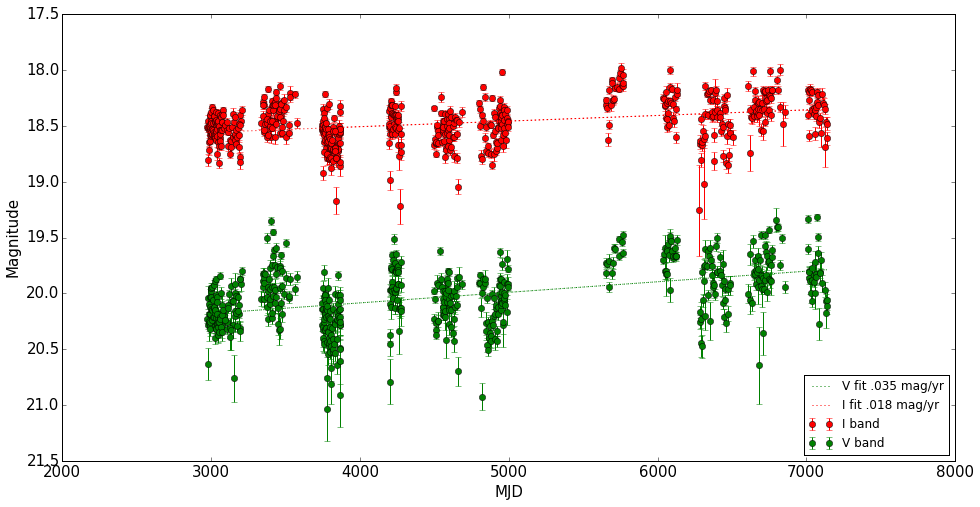

In [56]:
regVmag=linear_model.LinearRegression()
regImag=linear_model.LinearRegression()

#now we trian the model on our data sets. we have to drop any NaNs, or else the regression algorithm wont work
regVmag.fit((NMV.drop(indeciesToDropV).juliandate - 2450000).reshape(-1,1)
            ,NMV.drop(indeciesToDropV).NMcal.values.reshape(-1,1))
regImag.fit((NMI.drop(indeciesToDropI).juliandate - 2450000).values.reshape(-1,1),
            NMI.drop(indeciesToDropI).NMcal.values.reshape(-1,1))

#now lets try remaking that plot!
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(111)

ax.errorbar(NMI.drop(indeciesToDropI).juliandate - 2450000,
            NMI.drop(indeciesToDropI).NMcal, yerr=NMI.drop(indeciesToDropI).merr1,
            fmt='ro',label='I band')
ax.errorbar(NMV.drop(indeciesToDropV).juliandate - 2450000,
            NMV.drop(indeciesToDropV).NMcal, yerr=NMV.drop(indeciesToDropV).merr1,
            fmt='go', label='V band')

#and also plot the model, using the observation dates as inputs
ax.plot((NMV.drop(indeciesToDropV).juliandate - 2450000).values.reshape(-1,1).astype(float),
        regVmag.predict((NMV.drop(indeciesToDropV).juliandate - 2450000).values.reshape(-1,1).astype(float)),
        color='green',linestyle=':', label='V fit .035 mag/yr')

ax.plot((NMI.drop(indeciesToDropI).juliandate - 2450000).values.reshape(-1,1).astype(float),
        regImag.predict((NMI.drop(indeciesToDropI).juliandate - 2450000).values.reshape(-1,1).astype(float)),
        color='red',linestyle=':', label='I fit .018 mag/yr')

ax.invert_yaxis()
ax.set_ylabel('Magnitude')
ax.set_xlabel('MJD')
ax.legend(loc='lower right')

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)

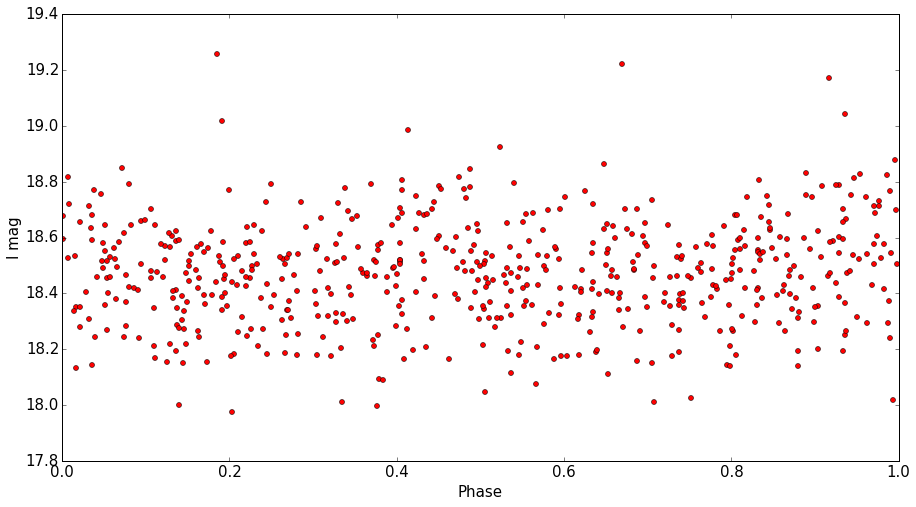

In [58]:
fig=plt.figure(figsize=(15,8))
ax=fig.add_subplot(111)

t=.4326

ax.plot((NMI.drop(indeciesToDropI)['juliandate'].values.astype(float)%t)/(t),
        NMI.drop(indeciesToDropI)['NMcal'],'ro',ms=5)

ax.set_xlabel('Phase')
ax.set_ylabel('I mag')
ax.invert_yaxis()

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)
    
plt.show()

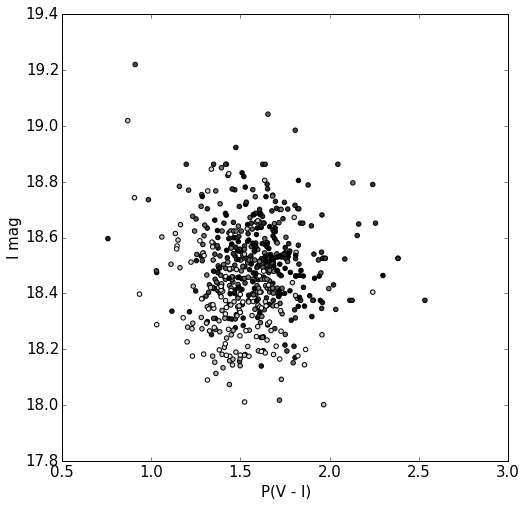

In [60]:
VI=pd.merge(NMV.drop(indeciesToDropV), NMI.drop(indeciesToDropI), on='date')
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)


plt.scatter(VI['NMcal_x']-VI['NMcal_y'],VI['NMcal_y'],c=VI['juliandate_x'].astype('float'), cmap='gray')

ax.set_xlabel('P(V - I)')
ax.set_ylabel('I mag')

for i in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    i.set_fontsize(15)
    
plt.show()

In [45]:
calI=pd.read_csv('photCalI.csv').drop('Unnamed: 0', axis=1)
calV=pd.read_csv('photCalV.csv').drop('Unnamed: 0', axis=1)
IVCalmerge=pd.merge(calI, calV, on='date', how='inner')

In [46]:
pd.DataFrame({'NMIV':(IVCalmerge.mag1_x - IVCalmerge.mag1_y).describe(),
              'mag3IV':(IVCalmerge.mag3_x - IVCalmerge.mag3_y).describe(),
              'mag4IV':(IVCalmerge.mag4_x - IVCalmerge.mag4_y).describe(),
              'mag5IV':(IVCalmerge.mag5_x - IVCalmerge.mag5_y).describe(),
              'mag9IV':(IVCalmerge.mag9_x - IVCalmerge.mag9_y).describe(),
              'mag10IV':(IVCalmerge.mag10_x - IVCalmerge.mag10_y).describe(),
              'mag17IV':(IVCalmerge.mag17_x - IVCalmerge.mag17_y).describe(),
              'mag19IV':(IVCalmerge.mag19_x - IVCalmerge.mag19_y).describe(),
              'mag20IV':(IVCalmerge.mag20_x - IVCalmerge.mag20_y).describe(),}).loc[['mean','std']]

,NMIV,mag10IV,mag17IV,mag19IV,mag20IV,mag3IV,mag4IV,mag5IV,mag9IV
mean,-1.585029,-1.295769,-1.039254,-1.036984,-1.394796,-1.420157,-1.366284,-1.171510,-0.967634
std,0.207547,0.056073,0.045255,0.036559,0.045588,0.035190,0.035091,0.080528,0.036221


In [110]:
#some points survieved. I'm curious about them
NMI.columns

Index([u'Unnamed: 0', u'date', u'juliandate', u'NMraw', u'mag3', u'mag4', u'mag5', u'mag9', u'mag10', u'mag17', u'mag19', u'mag20', u'merr1', u'offset', u'std', u'NMcal'], dtype='object')

In [36]:
NMV[NMV.NMcal >  21.3]

,Unnamed: 0,date,juliandate,NMraw,mag3,mag4,mag9,mag10,mag17,mag19,mag20,merr1,offset,std,NMcal
69,69,50511,2453502.52999,25.734,20.922,21.360,20.643,20.119,22.054,21.012,22.381,0.557,4.183000,0.018312,21.551000
202,202,70625,2454277.51175,24.606,19.869,20.266,19.590,19.075,21.110,19.919,21.366,0.589,3.140714,0.052560,21.465286
391,391,130328,2456380.65250,24.170,19.486,19.969,19.244,18.730,20.658,19.627,21.016,0.472,2.788571,0.020444,21.381429


In [164]:
indeciesToDropI

Int64Index([246, 271, 272, 278, 280, 301, 399, 421, 422, 423, 479], dtype='int64')

In [42]:
NMI.drop(indeciesToDropI).ix[:,['juliandate','NMcal','merr1']].applymap(lambda x: '%.3f' % x).to_csv('NovaMusca1991_Iband.txt', sep=' ', index=False)

In [43]:
NMV.drop(indeciesToDropV).ix[:,['juliandate','NMcal','merr1']].applymap(lambda x: '%.3f' % x).to_csv('NovaMusca1991_Vband.txt', sep=' ', index=False)